In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## Load all the necessary packages

%matplotlib inline

import matplotlib.pyplot as plt
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os
import PIL
import pandas as pd
import imageio


from matplotlib.pyplot import imread
import cv2
import h5py

In [3]:
## Load Directory Paths

def load_path(path):
    directories = []
    if os.path.isdir(path):
        print('directory path: ', path)
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            print('inside nested dir')
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    print('directories: ', directories)
    return directories

In [4]:
## Load Images from directory

def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = cv2.imread(os.path.join(d,f))
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
    
    print('list of files: ',len(files))
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return files   

In [5]:
def load_matdata_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = h5py.File(os.path.join(d,f), 'r')
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
    
    print('list of files: ',len(files), 'file: ', files[0])
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return files  

In [6]:
## Load Images

def load_data(directory, ext):
    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [7]:
## Load .mat data files

def load_matdata(directory, ext):
    files = load_matdata_from_dirs(load_path(directory), ext)
    return files

In [8]:
matfiles = load_matdata("../input/mydataset/BrainTumorData/", ".mat")

directory path:  ../input/mydataset/BrainTumorData/
directories:  ['../input/mydataset/BrainTumorData/']
list of files:  3064 file:  <HDF5 file "2912.mat" (mode r)>
list of files path:  3064 file path:  ../input/mydataset/BrainTumorData/2912.mat
Files Read:  3064


In [9]:
## get mask for the images

images_h5 = matfiles[:1000]
mask_arr = [img_h5['cjdata']['tumorMask'][()].astype(np.uint32) for img_h5 in images_h5]

In [10]:
## remove mask not of dimensions 512x512

fil_mask_arr = []
for mask in mask_arr:
    if mask.shape == (512,512):
        fil_mask_arr.append(mask)

In [11]:
## get mask for sr images

img_mask = []
for i in range(600,800):
    img_mask.append(fil_mask_arr[i])

In [12]:
## Load SR Images from directory

sr_imgs = load_data("../input/espcn-results/results/SR_Images/", ".jpeg")

directory path:  ../input/espcn-results/results/SR_Images/
directories:  ['../input/espcn-results/results/SR_Images/']
list of files:  200
list of files path:  200 file path:  ../input/espcn-results/results/SR_Images/SR_103.jpeg
Files Read:  200


In [13]:
## Normalize pixel values between 0 - 255

sr_images_norm = []
for i in range(len(sr_imgs)):
    img = cv2.normalize(np.float32(sr_imgs[i]), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    sr_images_norm.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint32))

In [14]:
## Get Tumors from SR Images

sr_tumor_arr = array([img * mask for img, mask in zip(sr_images_norm, img_mask)], dtype=object)

In [15]:
len(sr_tumor_arr)

200

In [16]:
## Load HR Images from directory

hr_imgs = load_data("../input/espcn-results/results/HR_Images/", ".jpeg")

directory path:  ../input/espcn-results/results/HR_Images/
directories:  ['../input/espcn-results/results/HR_Images/']
list of files:  200
list of files path:  200 file path:  ../input/espcn-results/results/HR_Images/HighRes_170.jpeg
Files Read:  200


In [17]:
## Normalize pixel values between 0 - 255

hr_images_norm = []
for i in range(len(hr_imgs)):
    img = cv2.normalize(np.float32(hr_imgs[i]), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    hr_images_norm.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint32))

In [18]:
## Get Tumors from HR Images

hr_tumor_arr = array([img * mask for img, mask in zip(hr_images_norm, img_mask)], dtype=object)

In [19]:
len(hr_tumor_arr)

200

In [20]:
def displayImages(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(np.asarray(img_arr[i], dtype=float).squeeze(), cmap='gray')
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

In [21]:
def displayUMatImages(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(img_arr[i].get().astype('f'))
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

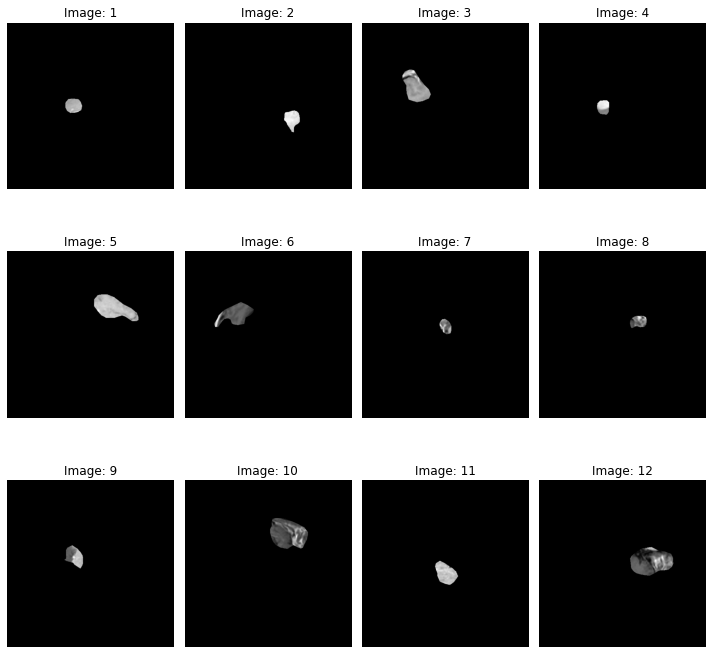

In [22]:
## Display SR Image Tumors

displayImages(sr_tumor_arr)

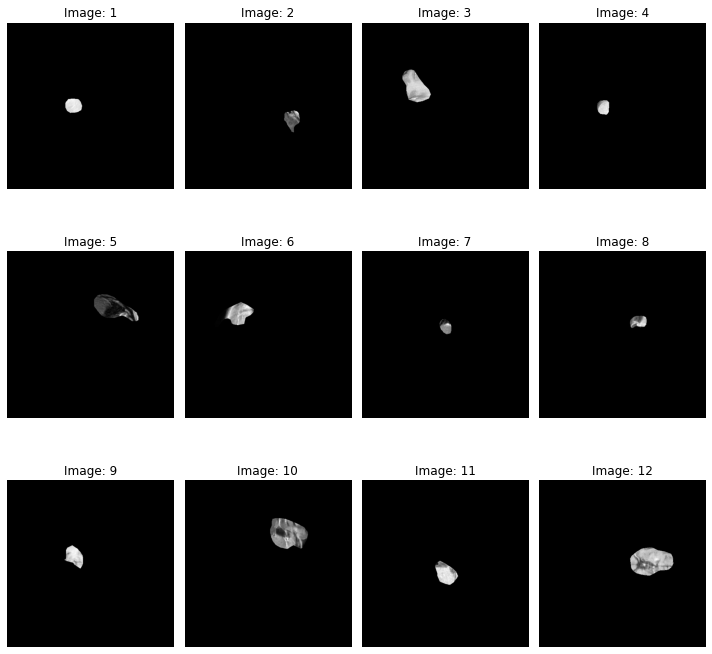

In [23]:
## Display SR Image Tumors

displayImages(hr_tumor_arr)

In [24]:
os.mkdir('./sr_tumor_imgs')
os.mkdir('./hr_tumor_imgs')

In [25]:
for idx in range(200):
    imageio.imwrite('./sr_tumor_imgs/SRTMR_'+str(idx+1)+'.jpeg', np.asarray(sr_tumor_arr[idx], dtype=float))
    imageio.imwrite('./hr_tumor_imgs/HRTMR_'+str(idx+1)+'.jpeg', np.asarray(hr_tumor_arr[idx], dtype=float))

In [26]:
%%!

zip -r sr_tumor.zip ./sr_tumor_imgs

['  adding: sr_tumor_imgs/ (stored 0%)',
 '  adding: sr_tumor_imgs/SRTMR_170.jpeg (deflated 42%)',
 '  adding: sr_tumor_imgs/SRTMR_148.jpeg (deflated 74%)',
 '  adding: sr_tumor_imgs/SRTMR_174.jpeg (deflated 69%)',
 '  adding: sr_tumor_imgs/SRTMR_150.jpeg (deflated 73%)',
 '  adding: sr_tumor_imgs/SRTMR_56.jpeg (deflated 62%)',
 '  adding: sr_tumor_imgs/SRTMR_167.jpeg (deflated 56%)',
 '  adding: sr_tumor_imgs/SRTMR_100.jpeg (deflated 57%)',
 '  adding: sr_tumor_imgs/SRTMR_158.jpeg (deflated 76%)',
 '  adding: sr_tumor_imgs/SRTMR_116.jpeg (deflated 58%)',
 '  adding: sr_tumor_imgs/SRTMR_138.jpeg (deflated 76%)',
 '  adding: sr_tumor_imgs/SRTMR_184.jpeg (deflated 46%)',
 '  adding: sr_tumor_imgs/SRTMR_130.jpeg (deflated 54%)',
 '  adding: sr_tumor_imgs/SRTMR_81.jpeg (deflated 54%)',
 '  adding: sr_tumor_imgs/SRTMR_69.jpeg (deflated 46%)',
 '  adding: sr_tumor_imgs/SRTMR_124.jpeg (deflated 78%)',
 '  adding: sr_tumor_imgs/SRTMR_57.jpeg (deflated 75%)',
 '  adding: sr_tumor_imgs/SRTMR_31.

In [27]:
%%!

zip -r hr_tumor.zip ./hr_tumor_imgs

['  adding: hr_tumor_imgs/ (stored 0%)',
 '  adding: hr_tumor_imgs/HRTMR_145.jpeg (deflated 51%)',
 '  adding: hr_tumor_imgs/HRTMR_62.jpeg (deflated 49%)',
 '  adding: hr_tumor_imgs/HRTMR_170.jpeg (deflated 38%)',
 '  adding: hr_tumor_imgs/HRTMR_46.jpeg (deflated 50%)',
 '  adding: hr_tumor_imgs/HRTMR_169.jpeg (deflated 78%)',
 '  adding: hr_tumor_imgs/HRTMR_185.jpeg (deflated 69%)',
 '  adding: hr_tumor_imgs/HRTMR_110.jpeg (deflated 75%)',
 '  adding: hr_tumor_imgs/HRTMR_92.jpeg (deflated 65%)',
 '  adding: hr_tumor_imgs/HRTMR_114.jpeg (deflated 53%)',
 '  adding: hr_tumor_imgs/HRTMR_150.jpeg (deflated 75%)',
 '  adding: hr_tumor_imgs/HRTMR_101.jpeg (deflated 66%)',
 '  adding: hr_tumor_imgs/HRTMR_153.jpeg (deflated 63%)',
 '  adding: hr_tumor_imgs/HRTMR_171.jpeg (deflated 80%)',
 '  adding: hr_tumor_imgs/HRTMR_44.jpeg (deflated 70%)',
 '  adding: hr_tumor_imgs/HRTMR_37.jpeg (deflated 44%)',
 '  adding: hr_tumor_imgs/HRTMR_49.jpeg (deflated 55%)',
 '  adding: hr_tumor_imgs/HRTMR_88.jp